# Convolutional Neural Network

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import mnist
%matplotlib inline

### Load Images and create kernels

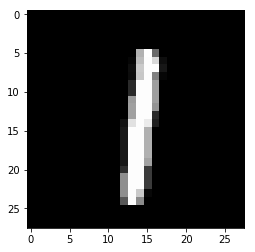

In [2]:
image = mnist.train_images()[40]
plt.imshow(image / 255 - .5, cmap='gray')

### Convolution
Funtion to perform a convolution for each kernel in kernelArray

In [3]:
def singleConvolution(image, kernel):
    imageW, imageH = image.shape
    kernelW, kernelH = kernel.shape
    
    convolvedImage = np.zeros((imageW-kernelW, imageH-kernelH))
    
    for i in range(imageW-kernelW):
        for j in range(imageH-kernelH):
            auxMatrix = image[i:i+kernelW,j:j+kernelH] * kernel
            convolvedImage[i, j] = auxMatrix.sum()
    return convolvedImage
            

def convolveImage(image, kernelArray):
    normalizedImage = (image / 255) - .5
    return np.array([ singleConvolution(normalizedImage, kernel) for kernel in kernelArray ])
    

### Random Kernels

In [4]:
NUMBER_KERNELS = 4
kernels = np.random.randn(NUMBER_KERNELS,3,3) / 9

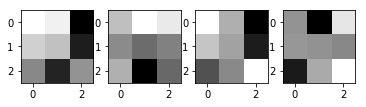

In [5]:
fig, axs = plt.subplots(1, min(NUMBER_KERNELS, 7))
for i in range(min(NUMBER_KERNELS, 7)):
    axs[i].imshow(kernels[i], cmap='gray')

### Apply kernels into the image

In [6]:
imagesConvolved = convolveImage(image, kernels)

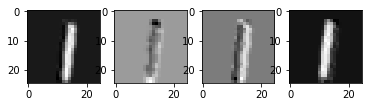

In [7]:
fig, axs = plt.subplots(1, min(NUMBER_KERNELS, 7))
for i in range(min(NUMBER_KERNELS, 7)):
    axs[i].imshow(imagesConvolved[i], cmap='gray')

### Pooling 
Apply an algorithm to group or reduce similar values to a simpler image

In [8]:
def pool(image, size = 2, function = np.max):
    w, h = image.shape
    sizeHorizontal = w // size
    sizeVertical = h // size

    ansImage = np.zeros([sizeVertical, sizeHorizontal])

    for i in range(sizeHorizontal):
        for j in range(sizeVertical):
            ansImage[i,j] = function(image[i*size:(i+1)*size, j*size:(j+1)*size])
    return ansImage

def poolImages(images, function=np.max):
    return np.array([pool(image, function=function, size = 2) for image in images])

### Apply pooling to the convolved images

In [9]:
imagesPooled = poolImages(imagesConvolved, function=np.median)

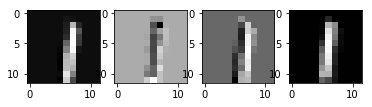

In [10]:
fig, axs = plt.subplots(1, min(NUMBER_KERNELS, 7))
for i in range(min(NUMBER_KERNELS, 7)):
    axs[i].imshow(imagesPooled[i], cmap='gray')

### Neural Layer
Now each processed image is flatted into a single array, and all pixel is treated as an input in our neural network

![Network configuration](images/CNN.svg)

In [11]:
def generateWeights(imageShape, output):
    inputlayer = np.prod(imageShape)
    weights = np.random.randn(inputlayer, output)
    return pd.DataFrame(weights)

### Generate weights for conections

In [12]:
weights = generateWeights(imagesPooled.shape, 10)
weights.tail()

,0,1,2,3,4,5,6,7,8,9
571,-0.365883,0.447099,-1.471752,0.583146,0.235899,-0.693070,-1.148435,-0.426485,0.423963,-0.358442
572,0.260679,0.296377,1.087194,-0.608515,-0.320272,-0.738035,0.412426,0.382567,0.418632,-1.497662
573,-0.036085,-0.527415,0.261306,0.637949,0.382641,-1.452442,-1.513402,0.383611,-1.070578,0.606564
574,0.713355,1.082814,1.327227,2.028021,-0.882122,0.307846,0.212370,0.143644,1.458235,-1.679590
575,-0.448185,-0.416336,1.756275,0.819101,0.965116,0.287789,-1.796784,0.151293,-0.797455,0.694138


### Apply weiths and cross-entropy to the image

In [13]:
def forwardSoftmax(imageDf, weightsDf):
    imagesWeigthed = imageDf.dot(weightsDf)
    exp = imagesWeigthed.apply(np.exp)
    return exp.apply(lambda row: row/row.sum(), axis=1)

### Flat the image in a single array as the input layer of the CNN

In [14]:
imageDf = pd.DataFrame(imagesPooled.flatten()).transpose()
imageDf

,0,1,2,3,4,5,6,7,8,9,...,566,567,568,569,570,571,572,573,574,575
0,-0.3337,-0.3337,-0.3337,-0.3337,-0.3337,-0.3337,-0.3337,-0.3337,-0.3337,-0.3337,...,-0.302526,-0.302526,-0.302526,-0.090786,-0.146472,-0.259637,-0.302526,-0.302526,-0.302526,-0.302526


### Apply forward algorithm

In [15]:
forwardSoftmax(imageDf, weights)

,0,1,2,3,4,5,6,7,8,9
0,0.000025,5.313375e-11,0.756235,0.211849,0.003326,0.02589,0.002589,0.000007,0.000079,7.119818e-08


# Test CNN 

In [16]:
test_images = mnist.test_images()[:1000]
test_labels = mnist.test_labels()[:1000]

In [17]:
def prepareImage(image):
    imageConvolved = convolveImage(image,kernels)
    imagePooled = poolImages(imageConvolved, function=np.max)
    return imagePooled.flatten()

### Get flat images DataFrame

In [18]:
preparedImages = map(prepareImage, test_images)
imagesDf = pd.DataFrame(preparedImages)
imagesDf.tail()

,0,1,2,3,4,5,6,7,8,9,...,566,567,568,569,570,571,572,573,574,575
995,-0.3337,-0.3337,-0.3337,-0.3337,-0.312449,-0.262166,-0.242216,-0.293809,-0.3337,-0.3337,...,-0.244166,-0.144005,-0.211702,-0.242645,-0.277219,-0.302526,-0.302526,-0.302526,-0.302526,-0.302526
996,-0.3337,-0.3337,-0.3337,-0.3337,-0.281078,-0.263877,-0.279116,-0.297726,-0.3337,-0.3337,...,-0.277077,-0.291913,-0.275328,-0.294639,-0.302526,-0.302526,-0.302526,-0.302526,-0.202739,-0.271358
997,-0.3337,-0.3337,-0.3337,-0.3337,-0.333700,-0.333700,-0.333700,-0.333700,-0.3337,-0.3337,...,-0.196728,-0.028201,0.051381,0.053033,0.051786,-0.057086,-0.206829,-0.295549,-0.302526,-0.302526
998,-0.3337,-0.3337,-0.3337,-0.3337,-0.333700,-0.333700,-0.333700,-0.333700,-0.3337,-0.3337,...,-0.302526,-0.295044,-0.151648,-0.114055,-0.114500,-0.164321,-0.232450,-0.282807,-0.302526,-0.302526
999,-0.3337,-0.3337,-0.3337,-0.3337,-0.333700,-0.333700,-0.333700,-0.333700,-0.3337,-0.3337,...,-0.302526,-0.302526,-0.302526,-0.302526,0.185990,0.116964,-0.204386,-0.302526,-0.302526,-0.302526


### So we can see that it has a low capacity to predict the numbers

In [19]:
answer = forwardSoftmax(imagesDf, weights) # Get probabilities
answer['ans'] = answer.idxmax(axis=1) # Get higher probability
answer['label'] = test_labels
answer.head()

,0,1,2,3,4,5,6,7,8,9,ans,label
0,7.718089e-08,3.394441e-07,6.040525e-02,8.691775e-01,5.348959e-02,0.014850,9.590300e-06,0.000055,2.026744e-05,1.992450e-03,3,7
1,5.832936e-02,1.205779e-04,2.232700e-01,1.561517e-03,7.978689e-03,0.676648,1.100980e-02,0.021023,1.066941e-05,4.769930e-05,5,2
2,1.169422e-06,2.042410e-10,9.195902e-01,3.511166e-02,4.862756e-04,0.043952,5.307564e-04,0.000007,3.204025e-04,1.244197e-07,2,1
3,1.002083e-10,3.950798e-11,1.002273e-07,2.767226e-10,2.522773e-09,0.999055,3.595736e-08,0.000945,8.564352e-09,9.797241e-08,5,0
4,1.124562e-06,3.117093e-05,3.214792e-04,1.415846e-03,1.290378e-04,0.996970,3.873978e-06,0.000639,9.769264e-05,3.902495e-04,5,4
